# Zpracování spekter

In [1]:
from widgets.data import Data
import numpy as np
import scipy.signal
import scipy.interpolate as si
import matplotlib.pyplot as plt

# CRR

(85, 60)
0.0
1.2392284
4.60706090927124
3.717685103416443
max Z val: 543.64697265625
min Z val: -758.1380004882812


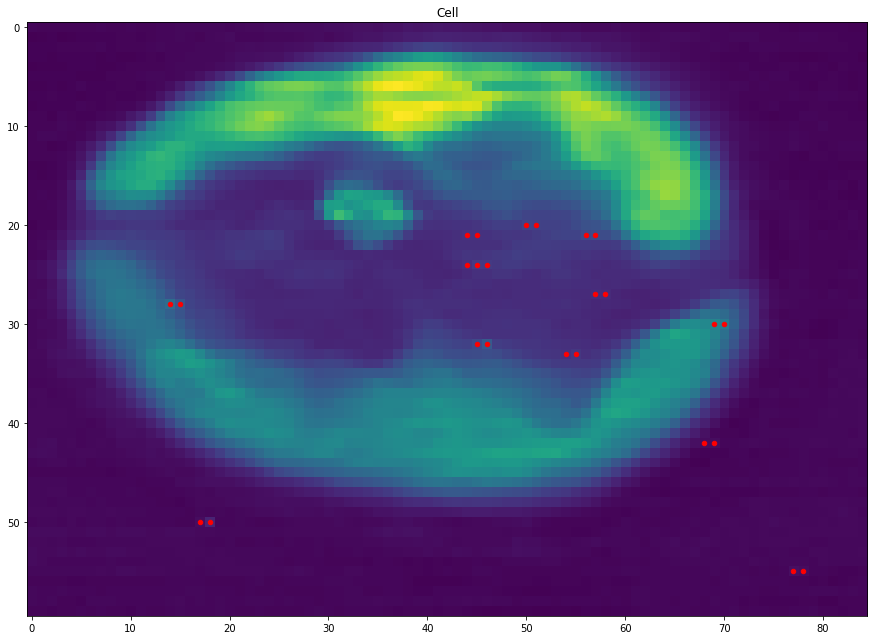

(85, 60, 1599)


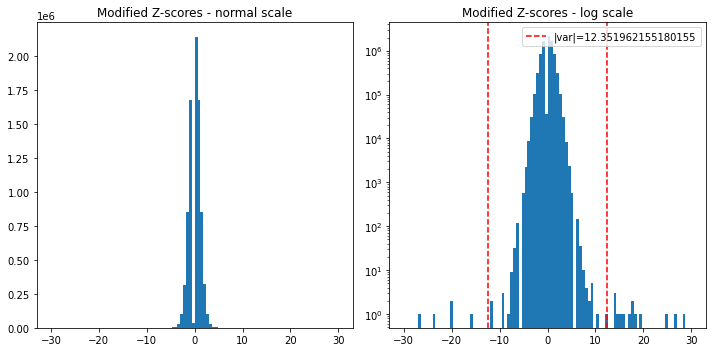

In [14]:
data = Data("./data/Cryptomonas.mat")
# data = Data("./data/Bigelowiella.mat")
# (Darren A. Whitaker, Kevin Hayes)
th = 10 # th zda se zavisi na bunce dost

diff = np.diff(data.data, axis=2)
M = np.median(diff, axis=2)
print(M.shape)
wide_M = np.repeat(M[:,:,np.newaxis], diff.shape[2], axis=2)
MAD = np.median(np.abs(diff-wide_M), axis=2)
Z = 0.6745 * (diff - wide_M) / np.repeat(MAD[:,:,np.newaxis], diff.shape[2], axis=2)
# print(Z.shape) # shape check

##############################################################
from scipy import stats

# print(S_Z.shape)
Z_vals = np.reshape(Z, (np.prod(Z.shape),))
Z_scores = stats.zscore(Z_vals)
# Z_vals = np.abs(Z_scores)
var = np.var(Z_vals)
std = np.std(Z_vals)
mean = np.mean(Z_vals)
print(np.median(Z_vals))
print(np.std(Z_vals))
print(3*var)
print(3*std)
var_log = (np.exp(var) - 1)*np.exp(2*mean+var)
log_std = np.sqrt(var_log)
# print(var_log := (np.exp(var) - 1)*np.exp(2*mean+var)) # https://en.wikipedia.org/wiki/Log-normal_distribution
# print(3*np.sqrt(var_log))

th = 3*log_std
# th = np.square(log_std)
print(f"max Z val: {np.max(Z_vals)}")
print(f"min Z val: {np.min(Z_vals)}")
# parametry -> threshold + TODO pocet bodu ve spektru vedle sebe, ktere mohou byt maximalne s danym Z aby byly spike

pos, counts = np.unique(np.vstack(np.where(np.abs(Z) > th)[:2]).T, axis=0, return_counts=True)
# print(list(zip(pos, counts)))
# print(pos.shape)
x = [float(i[0]) for i in pos]
y = [float(i[1]) for i in pos]

#print(x)
#print(y)
plt.figure(figsize=(15,9))
plt.imshow(data.averages.T, zorder=1)
plt.scatter(x, y, color='red', zorder=2, s=20)
plt.axis('on')
plt.title("Cell")

plt.tight_layout()
plt.show()

# Z values histogram
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
  
# normal scale
print(Z.shape)
sp = Z[0,0,:]

plt.hist(Z_vals, 100, range=(-30, 30), log=0)
# plt.axvline(x=3.5, color='red', linestyle='--', label=f"{3.5}")
# plt.axvline(x=-3.5, color='red', linestyle='--')
plt.axis('on')
plt.title("Modified Z-scores - normal scale")

fig.add_subplot(1, 2, 2)

# log scale
plt.hist(Z_vals, 100, range=(-30, 30), log=1)
plt.axvline(x=th, color='red', linestyle='--', label=f"|var|={th}")
plt.axvline(x=-th, color='red', linestyle='--')
plt.axis('on')
plt.legend()
plt.title("Modified Z-scores - log scale")

plt.tight_layout()
plt.show()



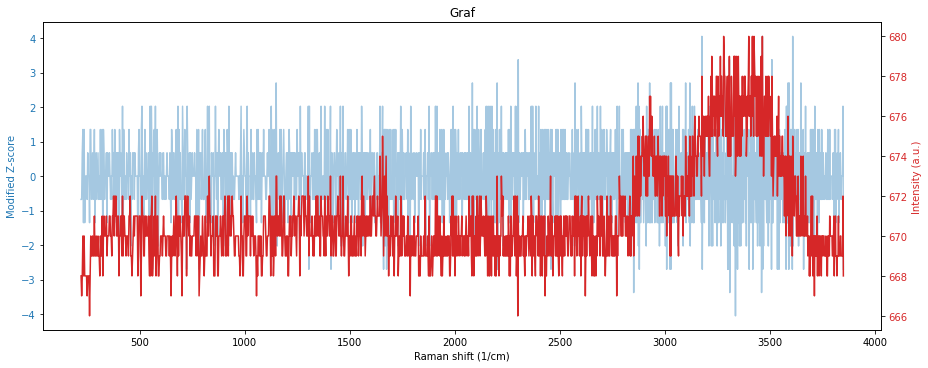

In [15]:
# plot spiky spectrum with z scores
fig, ax1 = plt.subplots(figsize=(13, 5))


color = 'tab:blue'
ax1.set_xlabel('Raman shift (1/cm)')
ax1.set_ylabel('Modified Z-score', color=color)  # we already handled the x-label with ax1
plt.plot(data.x_axis[1:], Z[27, 15, :], color=color, alpha=0.4) # tu pro Bigelowiellu
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Intensity (a.u.)', color=color)
plt.plot(data.x_axis[1:], data.data[27, 15, 1:], label='spectrum', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Graf")
plt.show()

# Spectra restoration

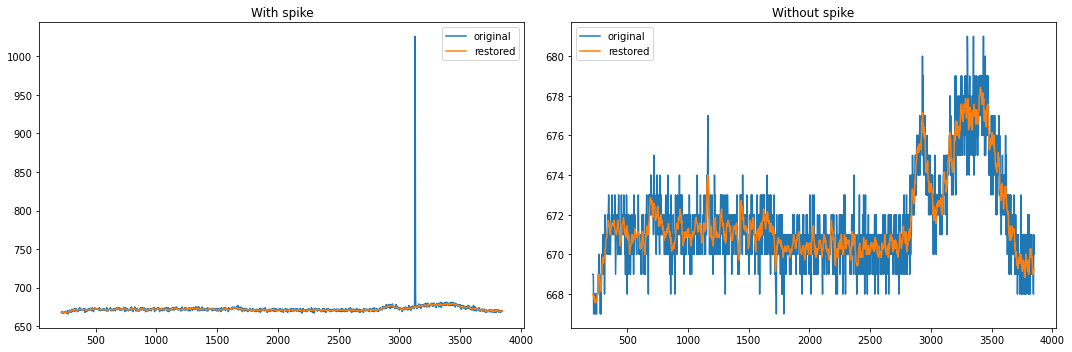

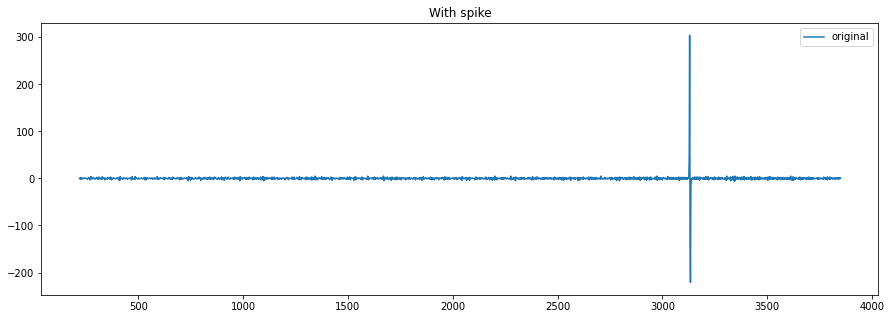

In [16]:
window_width = 3 # note that window width must be wide enough so that some valid signal falls into it

restored = np.empty_like(data.data)
new_Z = np.insert(Z, [0], np.full((Z.shape[0], Z.shape[1], 1), th + 1), axis=2) # add first Z value so that it exceeds the threshold automatically (in case it has spike)

window_mask = np.less_equal(np.abs(new_Z), np.full(new_Z.shape, th)).astype(np.float64)
window_mask_padded = np.pad(window_mask, ((0,0), (0,0), (window_width, window_width)))
divisors = np.apply_along_axis(np.convolve, 2, window_mask_padded, np.ones(2 * window_width + 1), 'valid') # counts how many ones are in the window (i.e. values that are below threshold)


masked_data = data.data * window_mask
masked_data_padded = np.pad(masked_data, ((0,0), (0,0), (window_width, window_width))) # pad with zeros to have the right shape after convolution
convolved_data = np.apply_along_axis(np.convolve, 2, masked_data_padded, np.ones(2 * window_width + 1), 'valid')

result = convolved_data / divisors

not_smoothed_result = np.where(masked_data > 0, data.data, result) # better, vzit z toho nejake grafy do prace

# plotting
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1)
  
# spectrum with spikes
plt.plot(data.x_axis, data.data[15, 28, :], label='original')
plt.plot(data.x_axis, result[15, 28, :], label='restored')
plt.legend()
plt.title("With spike")

fig.add_subplot(1, 2, 2)

# spectrum without spikes
plt.plot(data.x_axis, data.data[17, 28, :], label='original')
plt.plot(data.x_axis, result[17, 28, :], label='restored')
plt.legend()
plt.title("Without spike")

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15, 5))

# spectrum with spikes
plt.plot(data.x_axis[1:], diff[15, 28, :], label='original')
plt.legend()
plt.title("With spike")
plt.show()

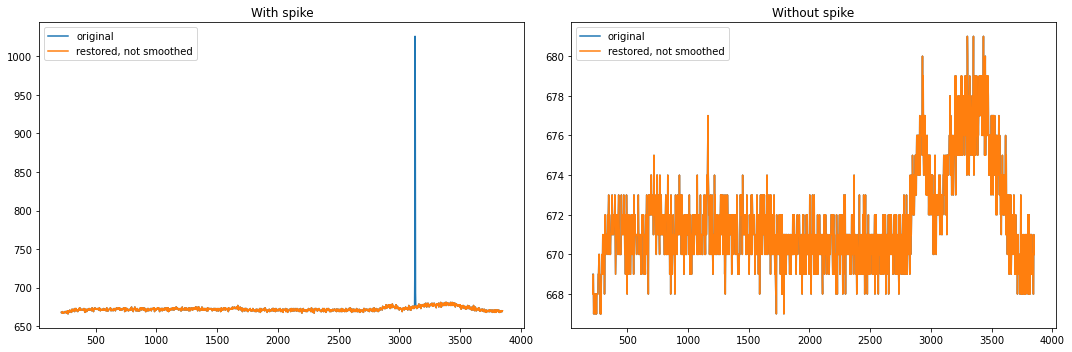

In [17]:
# not smoothed

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1)
# spectrum with spikes
plt.plot(data.x_axis, data.data[15, 28, :], label='original')
plt.plot(data.x_axis, not_smoothed_result[15, 28, :], label='restored, not smoothed')
plt.legend()
plt.title("With spike")

fig.add_subplot(1, 2, 2)

# spectrum without spikes
plt.plot(data.x_axis, data.data[17, 28, :], label='original')
plt.plot(data.x_axis, not_smoothed_result[17, 28, :], label='restored, not smoothed')
plt.legend()
plt.title("Without spike")

plt.tight_layout()
plt.show()

# BG Removal

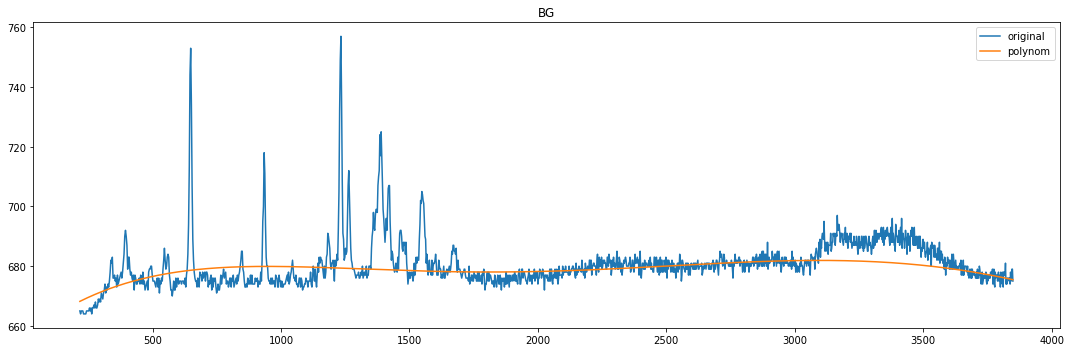

In [100]:
from functools import reduce

data = Data("./data/Bigelowiella.mat")

def get_indices_range(start_value, end_value):
    start_index = np.argmin(np.absolute(data.x_axis - start_value))
    end_index = np.argmin(np.absolute(data.x_axis - end_value))
    return np.r_[start_index:end_index]

ranges = [[3000, 3600], [1000, 1500]]
union = reduce(np.union1d, (get_indices_range(*i) for i in ranges))

to_plot = np.in1d(np.arange(data.x_axis.shape[0]), union, invert=True)

deg = 5 # will be param
x = data.x_axis
y = data.data[27, 15, :]
poly = np.polynomial.Polynomial(None).fit(x[to_plot], y[to_plot], deg=deg)
new_y = poly(x)

fig = plt.figure(figsize=(15, 5))

# spectrum with spikes
plt.plot(x, y, label='original')
plt.plot(x, new_y, label='polynom')
plt.legend()
plt.title("BG")

plt.tight_layout()
plt.show()

# BG Removal - Mathematical Morphology

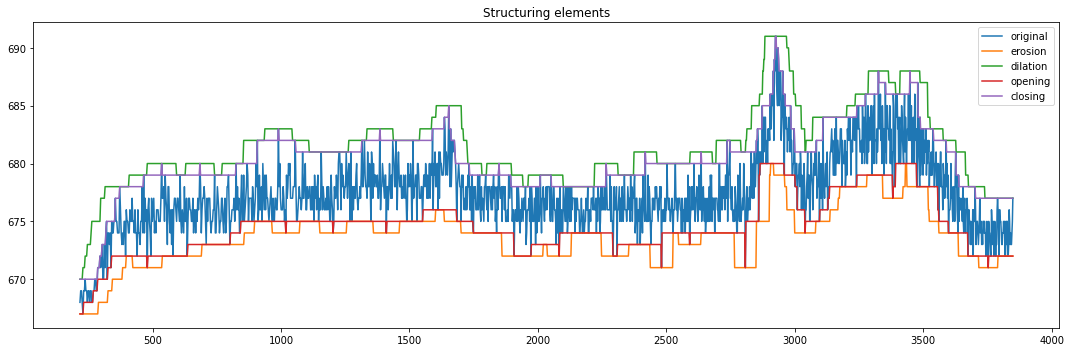

In [173]:
data = Data("./data/Cryptomonas.mat")
x = data.x_axis
y = data.data[30, 8, :]

def erosion(values: np.ndarray, window_width: int) -> np.ndarray: # start with 1 (structuring element has then size 3 (2 * w_w + 1))
    # eroze -> minmum v okně
    padded_values = np.pad(values, (window_width, window_width), 'constant', constant_values=(values[0], values[-1])) # pad with side values from sides
    windows = np.lib.stride_tricks.sliding_window_view(padded_values, 2 * window_width + 1)
    mins = np.min(windows, axis=1)
    return mins

def dilation(values: np.ndarray, window_width: int) -> np.ndarray:
    # dilatace -> maximum v okně
    padded_values = np.pad(values, (window_width, window_width), 'constant', constant_values=(values[0], values[-1])) # pad with side values from sides
    windows = np.lib.stride_tricks.sliding_window_view(padded_values, 2 * window_width + 1)
    mins = np.max(windows, axis=1)
    return mins

def opening(values: np.ndarray, window_width: int) -> np.ndarray:
    return dilation(erosion(values, window_width), window_width)

def closing(values: np.ndarray, window_width: int) -> np.ndarray:
    return erosion(dilation(values, window_width), window_width)

def top_hat(values: np.ndarray, window_width: int) -> np.ndarray:
    return values - opening(values, window_width)

# article window size = 41 -> width = 20
# plotting
ww = 20
fig = plt.figure(figsize=(15, 5))
plt.plot(x, y, label='original')
plt.plot(x, erosion(y, ww), label='erosion')
plt.plot(x, dilation(y, ww), label="dilation")
plt.plot(x, opening(y, ww), label="opening")
plt.plot(x, closing(y, ww), label="closing")
# plt.plot(x, top_hat(y, ww), label="top_hat")
plt.legend()
plt.title("Structuring elements")

plt.tight_layout()
plt.show()


Optimal window size: 109


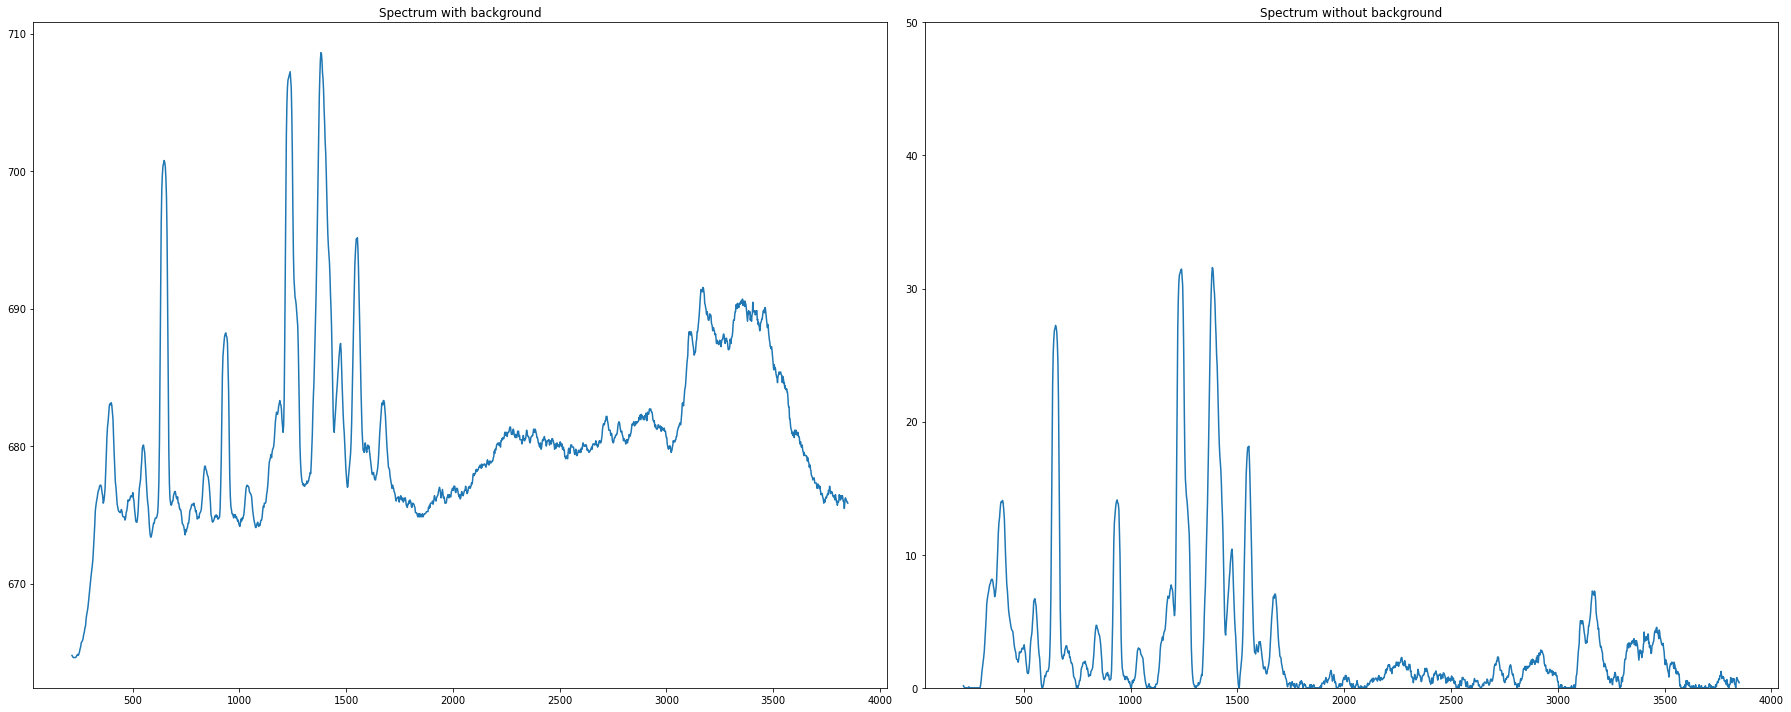

In [217]:
data = Data("./data/Cryptomonas.mat")
data = Data("./data/Bigelowiella.mat")
x = data.x_axis
y = data.data[27, 15, :] # 30, 8 (crypto), 27, 15 (bigel)
conv_win = 6
padded = np.pad(y, (conv_win, conv_win), 'constant', constant_values=(y[0], y[-1]))
y = np.convolve(padded, np.ones(2*conv_win + 1), 'valid') / (2*conv_win + 1)

# 1.
def get_optimal_structuring_element_width(values : np.ndarray) -> int:
    max_sim_counter = 4 # zmena oproti navrhovanemu algoritmu, potrebujeme vice (4 nebo 5 se zda byt ok)
    window_width = 1
    opened_array = opening(y, window_width)

    while True:
        window_width += 1
        new_opened_array = opening(opened_array, window_width)
        if np.any(new_opened_array != opened_array):
            similarity_counter = 0
            opened_array = new_opened_array
            continue
        else:
            similarity_counter += 1
            if similarity_counter == max_sim_counter:
                return window_width - max_sim_counter + 1 # restore window width of the first similar result

window_width = get_optimal_structuring_element_width(y)
print(f"Optimal window size: {2 * window_width + 1}")

# 2.
spectrum_opening = opening(y, window_width)
approximation = (erosion(spectrum_opening, window_width) + dilation(spectrum_opening, window_width)) / 2

optimum = np.minimum(spectrum_opening, approximation)

no_baseline_spectrum = y - optimum # top hat with computed value

# plotting
fig = plt.figure(figsize=(25, 10))
fig.add_subplot(1, 2, 1)
  
# spectrum with spikes
plt.plot(x, y)
plt.title("Spectrum with background")

fig.add_subplot(1, 2, 2)

# spectrum without spikes
plt.plot(x, no_baseline_spectrum)
plt.ylim(0, 50)
plt.title("Spectrum without background")

plt.tight_layout()
plt.show()


## Zekvidistantnění

!! až po odstranění spiků -> prokládání polynomem by dopadlo zle

old x axis: [ 360.68895374  363.53295308  366.3759651  ... 3809.29272249 3811.09830523
 3812.90343241], average step: 2.257825035097029
new x axis: [ 361.  362.  363. ... 3809. 3810. 3811.], average step: 1.0


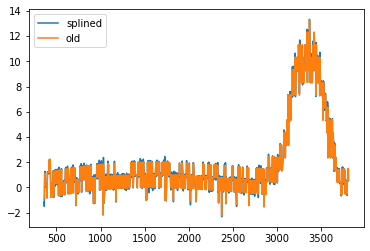

In [19]:
data = Data("./data/Cryptomonas_final.mat")

spectrum_spline = si.CubicSpline(data.x_axis, data.pure_data.T, extrapolate=False)
step_size = 1
new_x = np.arange(np.ceil(data.x_axis[0]), np.floor(data.x_axis[-1]), step_size)
new_data = spectrum_spline(new_x)

print(f"old x axis: {data.x_axis}, average step: {np.mean(np.abs(np.diff(data.x_axis)))}")
print(f"new x axis: {new_x}, average step: {np.mean(np.abs(np.diff(new_x)))}")

plt.plot(new_x, new_data[:,0], label='splined')
plt.plot(data.x_axis, data.pure_data[0,:], label='old')
plt.legend()
plt.show()

## Maska

Maska vytvořená pomocí integrálu nad lineární křivkou propojující krajní body vybraného intervalu s CH vibracemi.
Dále nutná ještě úprava pro vyplnění masky. Ideálně nejprve odstranění okolního šumu a následně vytvoření konvexního obalu.

Lepší se dá udělat pomocí aplikace K-Means na 2 komponenty.

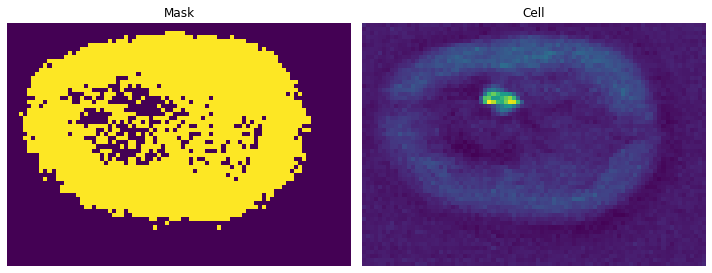

In [20]:
# normalization
threshold = 400 # above -> cell

start = 2800
end = 3050
index_of_start = np.where(new_x==start)[0][0]
index_of_end = np.where(new_x==end)[0][0]
norm_data = new_data[index_of_start:index_of_end,:]

integral = np.sum(norm_data, axis=0)
ref = ((norm_data[0,:] + norm_data[-1,:]) / 2) * norm_data.shape[0]

diff = np.reshape(integral - ref, (data.data.shape[0], data.data.shape[1])) > threshold

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
  
# showing image
plt.imshow(diff.T, interpolation='nearest')
plt.axis('off')
plt.title("Mask")

fig.add_subplot(1, 2, 2)

plt.imshow(data.averages.T, interpolation='nearest')
plt.axis('off')
plt.title("Cell")

plt.tight_layout()
plt.show()

## ICA

Rozklad na komponenty pomocí algoritmu FastICA. FastICA lze využít například i k detekci spiků nebo vytvoření masky.

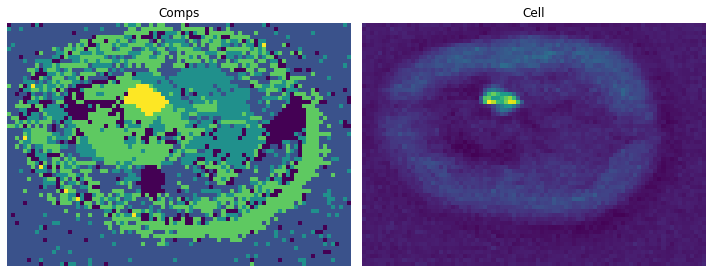

In [21]:
import sklearn.decomposition as sd

n_comp = 5
pca = sd.FastICA(n_components=n_comp)
r = pca.fit(data.pure_data).transform(data.pure_data)
r = np.argmax(np.abs(r), axis=1)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
  
# showing image
comp_im = np.reshape(r, (data.data.shape[0], data.data.shape[1]))
plt.imshow(comp_im.T, interpolation='nearest')
plt.axis('off')
plt.title("Comps")

fig.add_subplot(1, 2, 2)

plt.imshow(data.averages.T, interpolation='nearest')
plt.axis('off')
plt.title("Cell")

plt.tight_layout()
plt.show()

# PCA
normální klasická verze

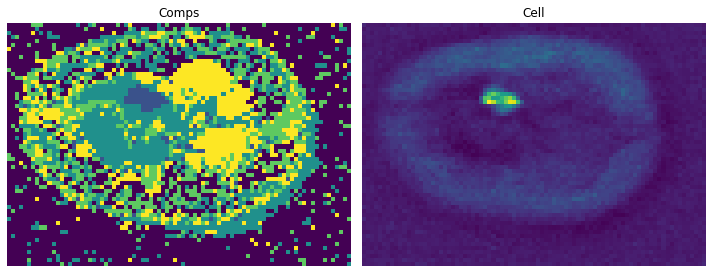

In [22]:
import sklearn.decomposition as sd

n_comp = 5
pca = sd.PCA(n_components=n_comp, whiten=True)
r = pca.fit(data.pure_data).transform(data.pure_data)
r = np.argmax(np.abs(r), axis=1)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
  
# showing image
comp_im = np.reshape(r, (data.data.shape[0], data.data.shape[1]))
plt.imshow(comp_im.T, interpolation='nearest')
plt.axis('off')
plt.title("Comps")

fig.add_subplot(1, 2, 2)

plt.imshow(data.averages.T, interpolation='nearest')
plt.axis('off')
plt.title("Cell")

plt.tight_layout()
plt.show()

# K-Means

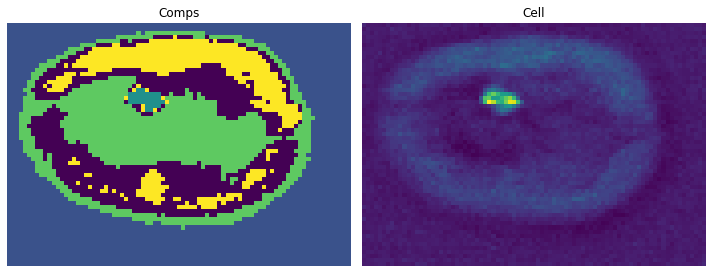

In [23]:
from sklearn import cluster

n_comp = 5
clf = cluster.KMeans(n_clusters=n_comp)
clf.fit(data.pure_data)

r = clf.predict(data.pure_data)


fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
  
# showing image
comp_im = np.reshape(r, (data.data.shape[0], data.data.shape[1]))
plt.imshow(comp_im.T, interpolation='nearest')
plt.axis('off')
plt.title("Comps")

fig.add_subplot(1, 2, 2)

plt.imshow(data.averages.T, interpolation='nearest')
plt.axis('off')
plt.title("Cell")

plt.tight_layout()
plt.show()

# K-Means Dropout

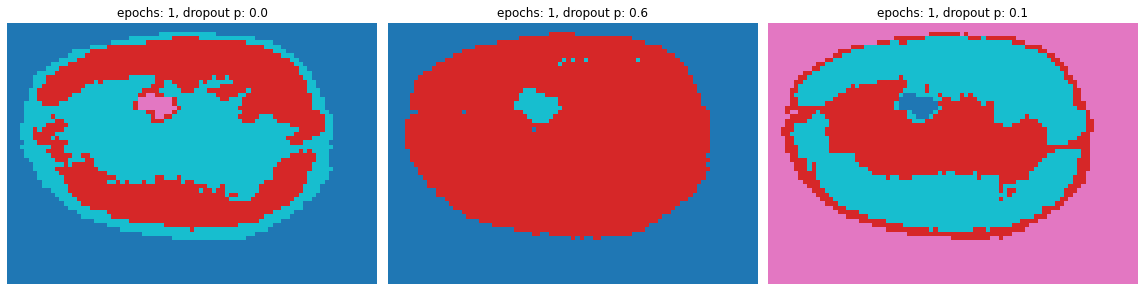

In [24]:
from sklearn import cluster
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

data = Data("./data/Cryptomonas_final.mat")

n_comp = 4

# dropout_ps = [0.0, 0.1, 0.2, 0.5]
# epochs = [3, 5, 7, 10]
dropout_ps = [0.0, 0.6, 0.1]
epochs = [1]

# majority voting
def train(epochs, dropout_p):
    results = []
    for _ in range(epochs):
        clf = cluster.KMeans(n_clusters=n_comp)
        random_noise = np.random.uniform(size=data.pure_data.shape)
        new_data = np.where(random_noise > dropout_p, data.pure_data, 0)
        clf.fit(new_data)
        results.append(clf.predict(data.pure_data))
        # result = result + clf.predict(data.pure_data)
    # result = result / epochs
    result = np.stack(results, axis=0)
    return scipy.stats.mode(result, axis=0).mode[0]


plt.figure(figsize=(16, 16))

for ie, e in enumerate(epochs):
    for ip, p in enumerate(dropout_ps):
        plt.subplot(len(epochs), len(dropout_ps), len(dropout_ps) * ie + ip + 1)
        comp_im = np.reshape(train(e,p), (data.data.shape[0], data.data.shape[1]))
        plt.imshow(comp_im.T, interpolation='nearest', cmap='tab10')
        plt.axis('off')
        plt.title(f"epochs: {e}, dropout p: {p}")

plt.tight_layout()
plt.show()